In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import h5py
from glob import glob

### theory data

In [2]:
THEORY_POWERS = [10, 50, 100]
THEORY_DELAYS = [10, 30, 50, 70, 90, 110]
THEORY_INTEGRATING_DELAYS = [25, 40, 75]

THEORY_XLIM = [0.5, 3.0]

def load_theory_result(power, delays=THEORY_DELAYS):

    dirmap = {
        10: "Iq_010",
        50: "Iq_050",
        100: "Iq_100",
    }

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"{dirmap[power]}/rdp47_{power:03d}_{delay:03d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def load_theory_integrating(power, delays=THEORY_INTEGRATING_DELAYS, box_size="30"):

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"Iq_long_pulse/rdp{box_size}_cal_{power:03d}_{delay:02d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def normalize(radial_profile, rng=(50, 340)):
    div = radial_profile[...,rng[0]:rng[1]].sum(-1)[...,None]
    return radial_profile / ( div + 1e-16)

### integrated pulses (original fig 5)

In [3]:
integrating_10power = load_theory_integrating(10, box_size="47")
integrating_100power = load_theory_integrating(100, box_size="47")

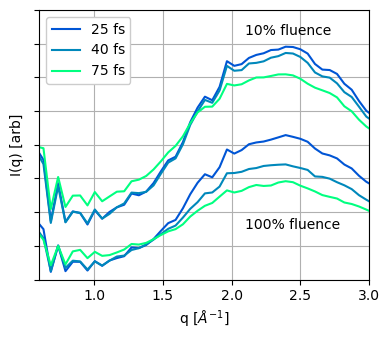

In [4]:
plt.figure(figsize=(4,3.5))

ax = plt.subplot(111)

for i,b in enumerate(THEORY_INTEGRATING_DELAYS):
    plt.plot(integrating_10power[:,0], integrating_10power[:,i+1] + 2e4, color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()))
    plt.plot(integrating_100power[:,0], integrating_100power[:,i+1], color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()), label="_nolegend_")

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.grid()
ax.set_xlim([0.6,3.0])
ax.set_yticklabels([])

plt.legend(
    ['%d fs' % b for b in THEORY_INTEGRATING_DELAYS], 
    prop={'size': 10},
    ncol=1,
    framealpha=1.0,
    loc=2
)

ax.text(2.1, 1.65e5, "10% fluence")
ax.text(2.1, 5.0e4, "100% fluence")
ax.set_ylim([2e4, 1.8e5])

plt.tight_layout()
plt.savefig("./integrated_pulse_simulation.png")
plt.show()

### experimental vs simulation (original figs 1 + 4)

In [5]:
experimental_data = np.loadtxt("../csvs/water_Iq_v_time.csv", delimiter=',')
print(experimental_data.shape)
EXPERIMENTAL_DELAYS = np.array([ 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0])

(500, 12)


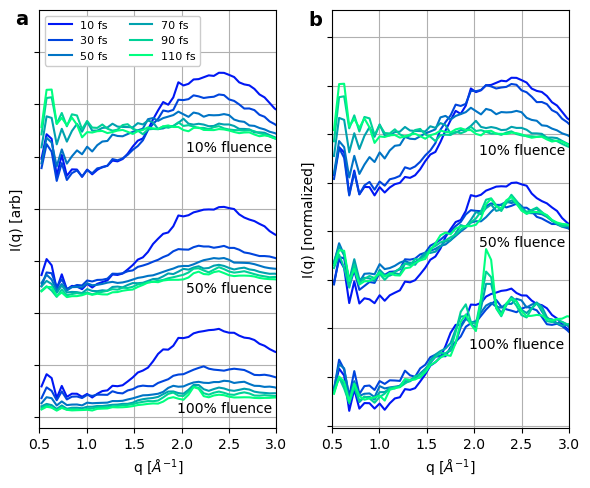

In [7]:
# just the simulation alone, normalized and unnormalized

GRID = True

fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(1, 2)

for ax_i in range(2):

    ax = fig.add_subplot(gs[ax_i])

    for power_index, theory_power in enumerate(THEORY_POWERS):

        theoretical_data = load_theory_result(theory_power)

        for i,b in enumerate(THEORY_DELAYS):

            if ax_i == 1:
                y = normalize(theoretical_data[:,i+1], rng=[0, -1])
                offset = 0.022
            else:
                y = theoretical_data[:,i+1]
                offset = 100000.0

            ax.plot(
                theoretical_data[:,0], y - power_index * offset,
                color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
            )

    if ax_i == 1:
        ax.set_ylabel('I(q) [normalized]')
        ax.text(0.25, 0.0425, "b", fontdict={'weight' : 'bold', 'size' : 14})
        ax.text(2.05,  0.016, f"10% fluence")
        ax.text(2.05, -0.003, f"50% fluence")
        ax.text(1.95, -0.024, f"100% fluence")
    
    else:
        ax.set_ylabel('I(q) [arb]')
        ax.text(0.25,  177000, "a", fontdict={'weight' : 'bold', 'size' : 14})
        ax.text(2.05,   55000, f"10% fluence")
        ax.text(2.05,  -80000, f"50% fluence")
        ax.text(1.95, -195000, f"100% fluence")

    ax.set_xlabel('q [$\AA^{-1}]$')
    ax.set_xlim(THEORY_XLIM)
    ax.set_yticklabels([])
    if GRID: ax.grid()

    if ax_i == 0:
        plt.legend(
            ['%d fs' % b for b in THEORY_DELAYS], 
            prop={'size': 8},
            ncol=2,
            framealpha=1.0,
            loc=2,
        )

    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax * 1.3])

plt.tight_layout()
plt.savefig("./simulation-only.png")
plt.show()

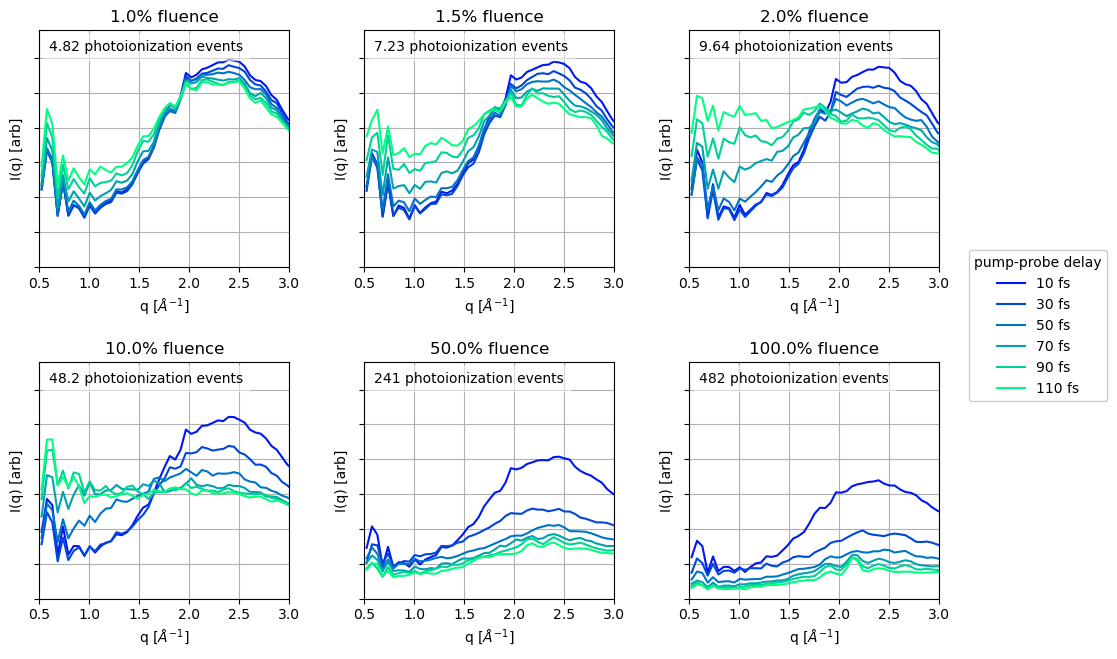

In [8]:
# power titration
# 
# unfortunately, the data for lower fluences was provided in a different
# format from the high power data...


def format_axis_for_power_titration(mpl_axes, power):
    mpl_axes.set_xlabel('q [$\AA^{-1}]$')
    mpl_axes.set_ylabel('I(q) [arb]')
    mpl_axes.set_xlim(THEORY_XLIM)
    mpl_axes.set_ylim([0, 170000])
    mpl_axes.set_yticklabels([])
    mpl_axes.grid()
    mpl_axes.set_title(f"{float(power)}% fluence")


# ----------
# low powers

POWER_TITRATION_POWERS = [
    "001",
    "0015",
    "002",
    #"0025",
    # "01", 
]

# these delays are the time in fs since the start of the simulation
# the pump pulse arrives at 30 fs
# so subtract 30 fs to obtain the corresponding high-power delay time in fs
POWER_TITRATION_TIME_DELAYS = ["040", "060", "080", "100", "120", "140"]

n_events_low_powers = ["4.82", "7.23", "9.64"]
n_events_high_powers = ["48.2", "241", "482"]

fig = plt.figure(figsize=(10,10))

add_to_legend = []

for power_index, theory_power_string in enumerate(POWER_TITRATION_POWERS):

    ax = fig.add_subplot(len(POWER_TITRATION_POWERS), 3, power_index+1)

    for time_delay in POWER_TITRATION_TIME_DELAYS:
        theory_power = float(f"{theory_power_string}".ljust(4, '0')) * 0.1
        file_name = f"./fluence_scan/rdp47_{theory_power_string}_{time_delay}.txt"
        theoretical_data = np.loadtxt(file_name)

        ax.plot(
            theoretical_data[:,0] * 1e-10,
            theoretical_data[:,1],
            color=plt.cm.winter(
                (float(time_delay) - 30)/(np.array([float(x) for x in POWER_TITRATION_TIME_DELAYS]).max()-30)
            )
        )

    n_events = n_events_low_powers[power_index]
    tb = ax.text(0.6, 1.55e5, f"{n_events!s} photoionization events")
    tb.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    format_axis_for_power_titration(ax, theory_power)

# -----------
# high powers

for power_index, theory_power in enumerate(THEORY_POWERS):

    ax = fig.add_subplot(
        len(POWER_TITRATION_POWERS), 
        3,
        power_index+1+len(POWER_TITRATION_POWERS)
    )
    theoretical_data = load_theory_result(theory_power)

    for i,b in enumerate(THEORY_DELAYS):
        ax.plot(
            theoretical_data[:,0],
            theoretical_data[:,i+1],
            color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
        )

    format_axis_for_power_titration(ax, theory_power)

    n_events = n_events_high_powers[power_index]
    tb = ax.text(0.6, 1.55e5, f"{n_events!s} photoionization events")
    tb.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))


plt.legend(
    [f'{float(delay):.0f} fs' for delay in THEORY_DELAYS], 
    framealpha=1.0,
    #loc=1,
    bbox_to_anchor=(1.7, 1.5), bbox_transform=ax.transAxes,
    prop={'size': 10},
    title="pump-probe delay",
    ncol=1,
)

#plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.4, wspace=0.3)
plt.savefig("./power_titration.png", bbox_inches="tight")
plt.show()

### oxygen ionization states (original figure 2)

- ion*: average ionization degree of oxygen
- first column: time[fs], 0fs = center of the pump pulse
- second column: average ionization degree [-]

- csp*: charge state population
- first column: time[fs], 0fs = center of the pump pulse
- columns 2 and higher give relative populations (0 to 1) of ionization stages of oxygen (neutral,1+,..)

note: figures do not show all columns that are included in data files.

In [9]:
csp_010 = np.genfromtxt("./charge_populations/csp47_010_single.txt")
csp_100 = np.genfromtxt("./charge_populations/csp47_100_single.txt")

ion_010 = np.genfromtxt("./charge_populations/ion47_010_single.txt")
ion_100 = np.genfromtxt("./charge_populations/ion47_100_single.txt")

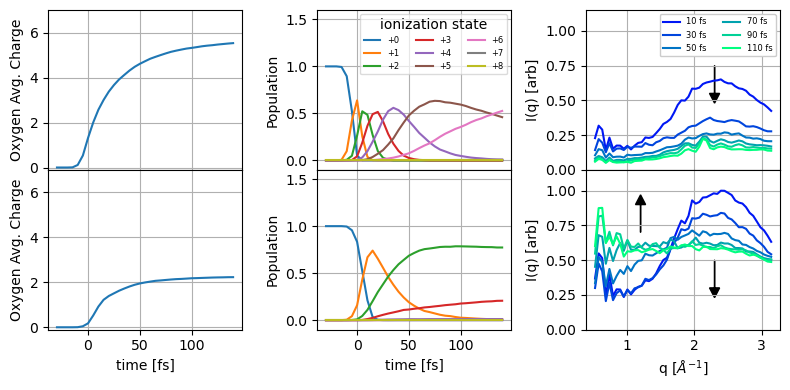

In [10]:
fix, axes = plt.subplots(2, 3, figsize=(8,4))

axes[0,0].plot(ion_100[:,0], ion_100[:,1])
axes[1,0].plot(ion_010[:,0], ion_010[:,1])

for i in range(2):
    axes[i,0].set_ylim([-0.1, 7.0])
    axes[i,0].set_ylabel("Oxygen Avg. Charge")
    axes[i,0].grid()

# --------

axes[0,1].plot(csp_100[:,0], csp_100[:,1:])
axes[1,1].plot(csp_010[:,0], csp_010[:,1:])

for i in range(2):
    axes[i,1].set_ylim([-0.1, 1.6])
    axes[i,1].set_ylabel("Population")
    axes[i,1].grid()

axes[0,1].legend(
    [f"+{i}" for i in range(9)],
    loc=1, 
    ncol=3,
    prop={'size': 6},
    framealpha=0.7,
    title="ionization state",
)

# --------

for i in range(2):

    if i == 0:
        theory_power = THEORY_POWERS[2]
    elif i == 1:
        theory_power = THEORY_POWERS[0]

    theoretical_data = load_theory_result(theory_power)
    for j,b in enumerate(THEORY_DELAYS):
        axes[i,2].plot(
            theoretical_data[:,0], theoretical_data[:,j+1] / 130347,  # 130347 = max
            color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
        )

    axes[i,2].grid()
    axes[i,2].set_ylim([0, 1.5e5 / 130347])
    axes[i,2].set_ylabel("I(q) [arb]")
    # axes[i,2].set_yticklabels([])

axes[1,2].set_xlabel("q [$\AA^{-1}]$")

axes[0,2].legend(
    ['%d fs' % b for b in THEORY_DELAYS], 
    prop={'size': 6},
    ncol=2,
    framealpha=1.0,
    loc=1,
)

axes[0,2].arrow(
    2.3, 0.75, 0, -0.2,
    color='k',
    head_width=0.15, 
    head_length=0.07
)
axes[1,2].arrow(
    1.2, 0.7, 0, 0.2,
    color='k',
    head_width=0.15, 
    head_length=0.07
)
axes[1,2].arrow(
    2.3, 0.5, 0, -0.2,
    color='k',
    head_width=0.15, 
    head_length=0.07
)

# --------

for i in range(2):
    axes[1,i].set_xlabel('time [fs]')

# --------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("ionization_states.png")
plt.savefig("ionization_states.pdf")
plt.show()

### form factor vs structure factor contribution (original figure 3)

In [11]:
def load_factor_block(fluence):

    data = [
        np.genfromtxt("./scattering_effect_decomposition/rdp47_undam_water.txt")[:,0] / 1e10,
        np.genfromtxt("./scattering_effect_decomposition/rdp47_undam_water.txt")[:,1],
        np.genfromtxt(f"./scattering_effect_decomposition/rdp47_{fluence}_disponly.txt")[:,1],
        np.genfromtxt(f"./scattering_effect_decomposition/rdp47_{fluence}_formfonly.txt")[:,1],
        np.genfromtxt(f"./scattering_effect_decomposition/rdp47_{fluence}_fulldam.txt")[:,1],
    ]

    return np.vstack(data).T

factor_block_010 = load_factor_block("010")
factor_block_100 = load_factor_block("100")

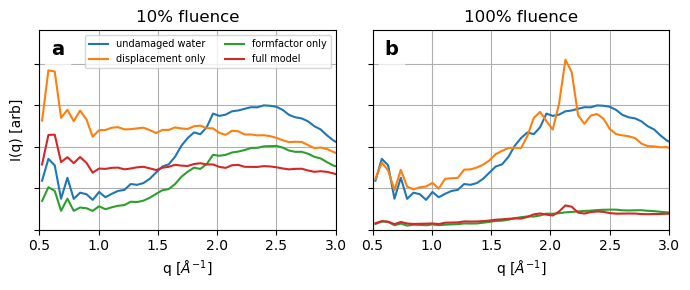

In [13]:
plt.figure(figsize=(7,3))

for ib, block in enumerate([factor_block_010, factor_block_100]):

    ax = plt.subplot(1, 2, ib+1)

    for i in range(4):
        plt.plot(block[:,0], block[:,i+1])

    ax.set_yticklabels([])
    ax.set_xlabel('q [$\AA^{-1}]$')
    ax.set_xlim(THEORY_XLIM)
    ax.set_ylim([0,2.4e5])
    ax.grid()

    if ib == 0:
        plot_label = "a"

        ax.set_title("10% fluence")
        ax.set_ylabel('I(q) [arb]')
        plt.legend(
            [
                "undamaged water",
                "displacement only",
                "formfactor only",
                "full model"
            ],
            loc=1,
            ncol=2,
            prop={'size': 7},
        )
    elif ib == 1:
        plot_label = "b"
        ax.set_title("100% fluence")

    text = ax.text(0.6, 2.1e5, plot_label, fontdict={'weight' : 'bold', 'size' : 14})
    text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.tight_layout()
plt.savefig("./paper_figures/figure4.pdf")
plt.savefig("./formfactor_vs_structurefactor.png")
plt.show()

## Original figure S1 and S2

In [15]:
low_fluence_si_data = np.vstack([
    np.genfromtxt(f"./box_size_10percent/rdp30_010_140fs_renorm.txt")[:,0] / 1e10,
    np.genfromtxt(f"./box_size_10percent/rdp30_010_140fs_renorm.txt")[:,1],
    np.genfromtxt(f"./box_size_10percent/rdp47_010_140fs.txt")[:,1],
    np.genfromtxt(f"./box_size_10percent/rdp60_010_140fs_renorm.txt")[:,1],
]).T

high_fluence_si_data = np.vstack([
    np.genfromtxt(f"./box_size_100percent/rdp30_100_140fs_renorm.txt")[:,0] / 1e10,
    np.genfromtxt(f"./box_size_100percent/rdp30_100_140fs_renorm.txt")[:,1],
    np.genfromtxt(f"./box_size_100percent/rdp47_100_140fs.txt")[:,1],
]).T


print(low_fluence_si_data.shape)
print(high_fluence_si_data.shape)

(50, 4)
(50, 3)


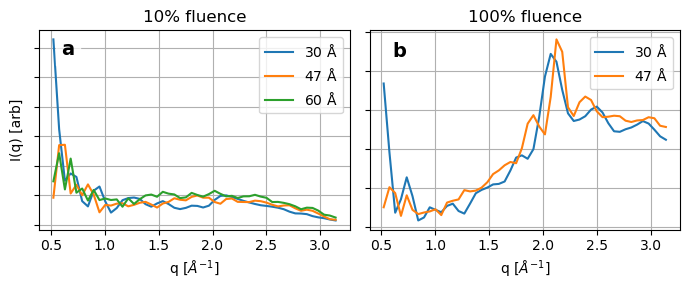

In [16]:
plt.figure(figsize=(7,3))

for ib, block in enumerate([low_fluence_si_data, high_fluence_si_data]):

    ax = plt.subplot(1, 2, ib+1)

    for i in range(block.shape[1]-1):
        plt.plot(block[:,0], block[:,i+1])

    ax.set_yticklabels([])
    ax.set_xlabel('q [$\AA^{-1}]$')
    #ax.set_xlim(THEORY_XLIM)
    #ax.set_ylim([0,2.4e5])
    ax.grid()

    plt.legend(
        [
            "30 $\mathrm{\AA}$",
            "47 $\mathrm{\AA}$",
            "60 $\mathrm{\AA}$",
        ],
        loc=1,
        ncol=1,
    )

    if ib == 0:
        plot_label = "a"
        ax.set_title("10% fluence")
        ax.set_ylabel('I(q) [arb]')
        text = ax.text(0.6, 1.75e5, plot_label, fontdict={'weight' : 'bold', 'size' : 14})

    elif ib == 1:
        plot_label = "b"
        ax.set_title("100% fluence")
        text = ax.text(0.6, 2.68e4, plot_label, fontdict={'weight' : 'bold', 'size' : 14})

    text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.tight_layout()
plt.savefig("./supplementary_figure_effect_of_box.png")
plt.show()

### Plot of power dependence

In [29]:
# --- peak positions to monitor later (in array idx)
new_peak_pos = 98
wat_peak_pos = 280

iq_vs_power_data = {}
iq_vs_power_CIs  = {}

for power_csv in glob("../csvs/water_Iq_v_power_??fs.csv") + glob("../csvs/water_Iq_v_power_???fs.csv"):
    print(f"loading {power_csv}")
    data = np.loadtxt(power_csv, delimiter=',')
    delay = float(power_csv.split("_")[-1].split(".")[0][:-2])
    iq_vs_power_data[delay] = data

for power_csv in glob("../csvs/water_Iq_v_power_95percentCI_*fs.csv"):
    print(f"loading {power_csv}")
    data = np.loadtxt(power_csv, delimiter=',')
    delay = float(power_csv.split("_")[-1].split(".")[0][:-2])
    iq_vs_power_CIs[delay] = data

loading ../csvs/water_Iq_v_power_50fs.csv
loading ../csvs/water_Iq_v_power_90fs.csv
loading ../csvs/water_Iq_v_power_70fs.csv
loading ../csvs/water_Iq_v_power_30fs.csv
loading ../csvs/water_Iq_v_power_10fs.csv
loading ../csvs/water_Iq_v_power_40fs.csv
loading ../csvs/water_Iq_v_power_80fs.csv
loading ../csvs/water_Iq_v_power_60fs.csv
loading ../csvs/water_Iq_v_power_20fs.csv
loading ../csvs/water_Iq_v_power_110fs.csv
loading ../csvs/water_Iq_v_power_100fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_20fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_60fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_40fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_80fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_100fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_10fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_30fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_70fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_110fs.csv
loading ../csvs/water_Iq_v_power_95percentCI_50f

In [30]:
time_delays = sorted(list(iq_vs_power_data.keys()))

time_power_data_stack = np.zeros((len(time_delays), iq_vs_power_data[time_delays[0]].shape[0]-1, iq_vs_power_data[time_delays[0]].shape[1]-2))
time_power_95ci_stack = np.zeros((len(time_delays), iq_vs_power_data[time_delays[0]].shape[0]-1, iq_vs_power_data[time_delays[0]].shape[1]-2))

for it, time_delay in enumerate(time_delays):
    time_power_data_stack[it,:,:] = iq_vs_power_data[time_delay][1:,2:]
    time_power_95ci_stack[it,:,:] = iq_vs_power_CIs[time_delay][1:,2:]

# shape: (time, q, power)
print(time_power_data_stack.shape)
print(time_power_95ci_stack.shape)

(11, 499, 9)
(11, 499, 9)


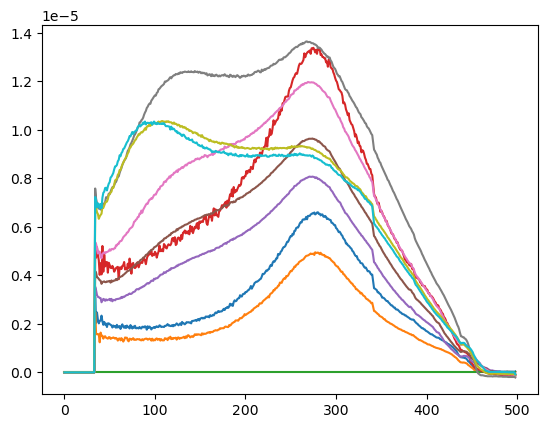

In [20]:
plt.figure()
for i in range(10):
    plt.plot(time_power_data_stack[i,:,5])
#plt.vlines([wat_peak_pos, new_peak_pos], 0, 0.008)
plt.show()

In [37]:
def compute_normalization_factor(radial_profile, rng=(60, 320)):
    # divide by this
    auc = radial_profile[:,rng[0]:rng[1],:].sum(1)[:,None,:]
    return auc + 1e-16
    
auc_to_mJ = 1.60324933931e-07

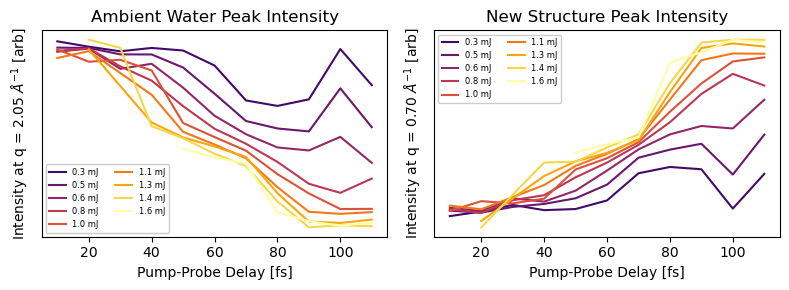

In [38]:
pump_powers = np.array([2000000.0,3000000.0,4000000.0,5000000.0,6000000.0,7000000.0,8000000.0,9000000.0,10000000])

normalization_factor = compute_normalization_factor(time_power_data_stack)
normalized_time_power_data_stack = time_power_data_stack / normalization_factor
normalized_time_power_95ci_stack = time_power_95ci_stack / normalization_factor

time_delays = np.array(time_delays)


plt.figure(figsize=(8,3))

ax = plt.subplot(121)
plt.title('Ambient Water Peak Intensity')
for power_index, power in enumerate(pump_powers):

    y = normalized_time_power_data_stack[:,wat_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        color=cm.inferno(power/pump_powers.max())
    )
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('Intensity at q = 2.05 $\AA^{-1}$ [arb]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
ax.get_yaxis().set_ticks([])
    
ax = plt.subplot(122)
plt.title('New Structure Peak Intensity')
for power_index, power in enumerate(pump_powers):
    
    y = normalized_time_power_data_stack[:,new_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        color=cm.inferno(power/pump_powers.max())
    )
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
plt.ylabel('Intensity at q = 0.70 $\AA^{-1}$ [arb]')
ax.get_yaxis().set_ticks([])
    
plt.tight_layout()
#plt.savefig('figures/peak_ints_vs_delay-power_%s.pdf' % ds_name)
plt.show()

## combine time and fluence dep.

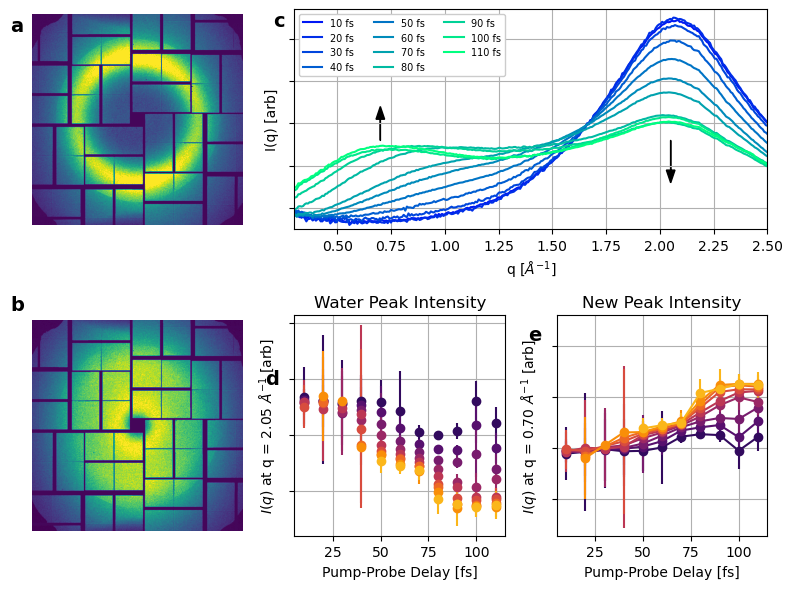

In [45]:
# just the experiment alone

XLIM = [0.3, 2.5]


fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 3)

probe_only = np.load("run129_10shot_average.npy")
pump_probe = np.load("run127_10shot_average.npy")
image_slice = np.s_[150:-150,150:-150]

ax = fig.add_subplot(gs[0,0])
probe_only[probe_only > 100] = 0
plt.imshow(probe_only[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, 115, "a", fontdict={'weight' : 'bold', 'size' : 14})

ax = fig.add_subplot(gs[1,0])
pump_probe[pump_probe > 100] = 0
plt.imshow(pump_probe[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, -70, "b", fontdict={'weight' : 'bold', 'size' : 14})

# -------------------------------

ax = fig.add_subplot(gs[0,1:])
for i,b in enumerate(EXPERIMENTAL_DELAYS):
    ax.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()))

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(XLIM)
ax.set_ylim([0.0015, 0.0067])
ax.set_yticklabels([])
if GRID: ax.grid()

ax.arrow(
    0.7, 0.0036, 0, 0.0005,
    color='k',
    head_width=0.04, 
    head_length=0.0003
)
ax.arrow(
    2.05, 0.0036, 0, -0.0007,
    color='k',
    head_width=0.04, 
    head_length=0.0003
)

plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=3,
    framealpha=1.0,
)

ax.text(0.2, 0.0063, "c", fontdict={'weight' : 'bold', 'size' : 14})

# -------------------------------

pump_powers = np.array([2000000.0,3000000.0,4000000.0,5000000.0,6000000.0,7000000.0,8000000.0,9000000.0,10000000])
normalized_time_power_data_stack = normalize(time_power_data_stack)

inferno_offset = 1.2 # changes color scale

time_delays = np.array(time_delays)

ax = fig.add_subplot(gs[1,1])
plt.title('Water Peak Intensity')
for power_index, power in enumerate(pump_powers):

    y = normalized_time_power_data_stack[:,wat_peak_pos,power_index]
    # plt.plot(
    #     time_delays[y>0],
    #     y[y>0],
    #     "o-",
    #     color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    # )
    plt.errorbar(
        time_delays[y>0],
        y[y>0],
        fmt="o",
        yerr=normalized_time_power_95ci_stack[:,wat_peak_pos,power_index][y>0],
        color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    )
    
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('$I(q)$ at q = 2.05 $\AA^{-1}$ [arb]')
# plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
#           prop={'size': 7}, ncol=2, framealpha=1.0)
ax.get_yaxis().set_ticklabels([])
ax.grid()
water_peak_ylim = ax.get_ylim()

ax.text(-10, 0.0078, "d", fontdict={'weight' : 'bold', 'size' : 14})

# ----
    
ax = fig.add_subplot(gs[1,2])
plt.title('New Peak Intensity')
for power_index, power in enumerate(pump_powers):
    
    y = normalized_time_power_data_stack[:,new_peak_pos,power_index]
    # plt.plot(
    #     time_delays[y>0],
    #     y[y>0],
    #     "o-",
    #     color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    # )
    plt.errorbar(
        time_delays[y>0],
        y[y>0],
        fmt="o-",
        yerr=normalized_time_power_95ci_stack[:,wat_peak_pos,power_index][y>0],
        color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    )
    
    
plt.xlabel('Pump-Probe Delay [fs]')
# plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
#           prop={'size': 7}, ncol=2, framealpha=1.0, frameon=True)
plt.ylabel('$I(q)$ at q = 0.70 $\AA^{-1}$ [arb]')
ax.get_yaxis().set_ticklabels([])
#ax.set_ylim(water_peak_ylim)

old_ylim = ax.get_ylim()
ax.set_ylim([old_ylim[0], old_ylim[1]*1.3])

ax.text(-10, 0.00625, "e", fontdict={'weight' : 'bold', 'size' : 14})
ax.grid()
    

plt.tight_layout()
plt.savefig("./paper_figures/figure1.pdf")
plt.savefig("./experiment_cspad_time_and_power.png")
plt.show()

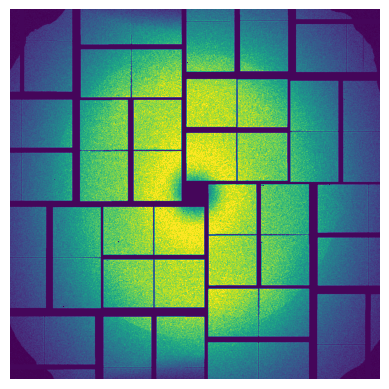

In [20]:
plt.figure()
ax = plt.subplot(111)
# probe_only[probe_only > 100] = 0
# plt.imshow(probe_only[image_slice], vmin=-1, vmax=60)
pump_probe[pump_probe > 100] = 0
plt.imshow(pump_probe[image_slice], vmin=-1, vmax=60)
ax.axis("off")
plt.savefig("pump_probe_cspad.pdf")
plt.show()


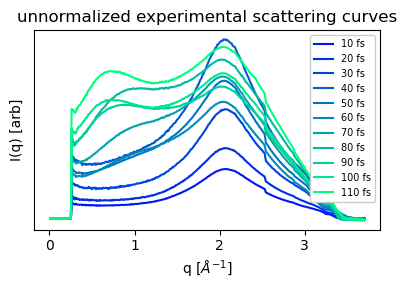

In [21]:
# unnormalized - by binning!

pump_powers = np.array([2000000.0,3000000.0,4000000.0,5000000.0,6000000.0,7000000.0,8000000.0,9000000.0,10000000])
time_delays = np.array(time_delays)


plt.figure(figsize=(4,3))
plt.title("unnormalized experimental scattering curves")

ax = plt.subplot(111)

for i,b in enumerate(EXPERIMENTAL_DELAYS):
    bin_y = time_power_data_stack[i,:,:].mean(-1)
    ax.plot(
        iq_vs_power_data[110.0][1:,0],
        bin_y[:],
        color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()),
    )
    
plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=1,
    framealpha=1.0,
)
ax.get_yaxis().set_ticks([])

    
plt.tight_layout()
#plt.savefig('figures/peak_ints_vs_delay-power_%s.pdf' % ds_name)
plt.show()

### ion and electron temperatures

In [22]:
# 1st column: time [fs] time = 0 fs at the pump pulse center
# 2nd column: electron concentration n_e [m^-3]
# 3rd column: electron temperature T_e [eV]
# 4th column: oxygen ion temperature T_i [eV]

low_fluence_temperatures = np.loadtxt("./temperature-data/noprobe_010.txt")
high_fluence_temperatures = np.loadtxt("./temperature-data/noprobe_100.txt")

# convert from 1/m3 to 1/cm3
low_fluence_temperatures[:,1] *= 1e-6
high_fluence_temperatures[:,1] *= 1e-6

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_57525/3391067184.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


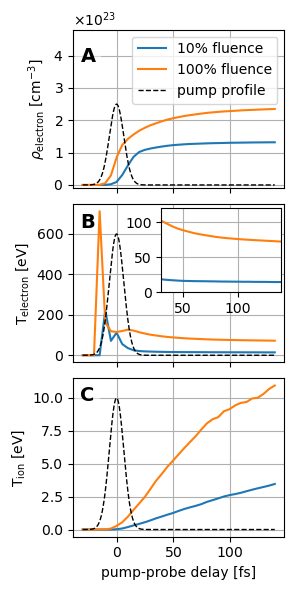

In [33]:
def gaussian(x, fwhm, mu):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(-np.square(x - mu) / (2 * np.square(sigma)))

gaussian_amplitudes = [2.5e23, 600, 10]
time_axis = np.linspace(-30, 140, 1000)

fig, axes = plt.subplots(3, 1, figsize=(3,6), sharex=True)

y_axes_labels = [
    r"$\rho_\mathrm{electron}$ [cm$^{-3}$]",
    "T$_\mathrm{electron}$ [eV]",
    "T$_\mathrm{ion}$ [eV]",
]

for it, temperature_data in enumerate([low_fluence_temperatures, high_fluence_temperatures]):

    for i in range(3):
        axes[i].plot(
            temperature_data[:,0],
            temperature_data[:,i+1],
        )
        axes[i].grid(True)
        axes[i].set_ylabel(y_axes_labels[i])

        # insert
        if i == 1:
            if it == 0:
                sub_axes = plt.axes([.54, .505, .4, .14]) 
            sub_axes.plot(
                temperature_data[:,0],
                temperature_data[:,i+1],
            )
            sub_axes.set_xlim([30,140])
            sub_axes.set_ylim([0,120])
            sub_axes.grid(True)

        if it == 1:
            axes[i].plot(
                time_axis,
                gaussian(time_axis, 15, 0) * gaussian_amplitudes[i],
                'k--',
                lw=1,
            )

axes[0].set_ylim([-1e22, 4.8e23])
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].ticklabel_format(useMathText=True)
axes[0].legend(["10% fluence", "100% fluence", "pump profile"], loc=1)
#axes[1].set_ylim([-5, 200])
axes[2].set_xlabel("pump-probe delay [fs]")

t1 = axes[0].text(-32, 3.8e23, "A", fontdict={'weight' : 'bold', 'size' : 14})
t1.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

t2 = axes[1].text(-32, 630, "B", fontdict={'weight' : 'bold', 'size' : 14})

t3 = axes[2].text(-32, 9.8, "C", fontdict={'weight' : 'bold', 'size' : 14})
t3.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

plt.tight_layout()
plt.subplots_adjust(hspace=.1)
plt.savefig("./paper_figures/figure3.pdf")
plt.savefig("temperatures.png")
plt.show()

### Gamma and Debye parameters

In [24]:
debye_gamma_columns = ["time [fs]", "$\lambda_{De}$ [$\AA$]", "$\lambda_\mathrm{D}$ [$\AA$]", "$\Gamma_\mathrm{e}$", "$\Gamma_\mathrm{H}$", "$\Gamma_\mathrm{O}$"]
debye_gamma_10percent = np.loadtxt("./gamma/deb_gam_10_single_pulse.txt", skiprows=1)
debye_gamma_100percent = np.loadtxt("./gamma/deb_gam_100_single_pulse.txt", skiprows=1)

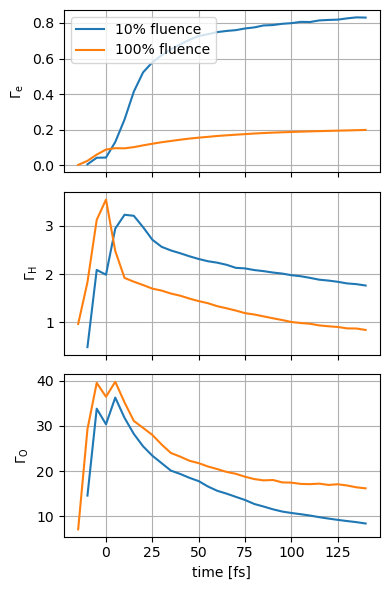

In [25]:
fig, axes = plt.subplots(3,1, figsize=(4,6), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)


for idx in range(3):
    ax = axes[idx]

    p1 = ax.plot(debye_gamma_10percent[:,0], debye_gamma_10percent[:,idx+3], label="10% fluence")
    p2 = ax.plot(debye_gamma_100percent[:,0], debye_gamma_100percent[:,idx+3], label="100% fluence")

    ax.set_ylabel(debye_gamma_columns[idx+3])
    ax.grid()

    if idx == 0:
        ax.legend(loc=2)

ax.set_xlabel(debye_gamma_columns[0])

plt.tight_layout()
plt.savefig("gamma_couplings.png")
plt.show()


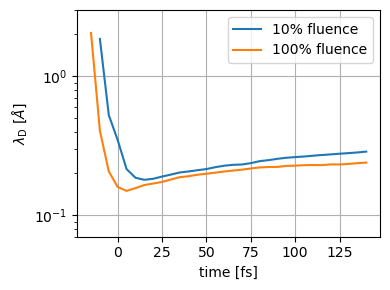

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(4,3), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)


for idx in [1]:
    ax = axes

    p1 = ax.plot(debye_gamma_10percent[:,0], debye_gamma_10percent[:,idx+1], label="10% fluence")
    p2 = ax.plot(debye_gamma_100percent[:,0], debye_gamma_100percent[:,idx+1], label="100% fluence")

    ax.set_ylabel(debye_gamma_columns[idx+1])
    ax.grid()
    ax.set_yscale('log')

ax.legend(loc=1)
ax.set_xlabel(debye_gamma_columns[0])
ax.set_ylim([0.07, 3])

plt.tight_layout()
plt.savefig("debye_lengths.png")
plt.show()


### Ion contamination

In [27]:
preprocessed_water_run = h5py.File("../preprocessed_data/run131.h5", "r")

q_values = np.array(preprocessed_water_run["radial_profile_qvalues"])
water_data = np.array(preprocessed_water_run["radial_profile"])
n_shots = water_data.shape[0]

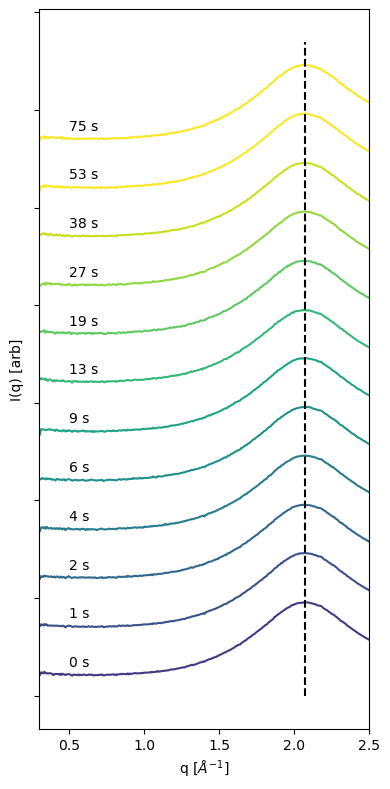

In [28]:
SHOTS_PER_TIME_BIN = 120
MAX_PLOTS = 12

plt.figure(figsize=(4,8))

ax_l = plt.subplot(111)
#ax_r = plt.subplot(122)

n_plots = int(n_shots / SHOTS_PER_TIME_BIN + 1)
for bin_index in range(2, MAX_PLOTS+2):

    time_slice_start = int(np.exp(bin_index / 3.0)) - 1 # int(bin_index ** 2)

    Iq = water_data[time_slice_start*SHOTS_PER_TIME_BIN:(time_slice_start+1)*SHOTS_PER_TIME_BIN,:].mean(axis=0)
    Iq_normalized = Iq / Iq[100:400].mean()
    offset =  bin_index

    ax_l.plot(
        q_values, 
        Iq_normalized + offset,
        color=cm.viridis(bin_index/MAX_PLOTS),
    )

    ax_l.text(0.5, offset+0.6, f"{time_slice_start} s")

    # if bin_index > 0:
    #     ax_r.plot(
    #         q_values, 
    #         (Iq_normalized - Iq_normalized_last) / (0.5 * (Iq_normalized + Iq_normalized_last)),
    #         color=cm.viridis(bin_index/MAX_PLOTS),
    #     )

    # Iq_normalized_last = Iq_normalized


ax_l.set_xlabel("q [$\AA^{-1}$]")
ax_l.set_ylabel("I(q) [arb]")
ax_l.set_xlim(XLIM)

ax_l.set_yticklabels([])
ax_l.vlines(2.07, 2, 15.4, color='k', linestyle='--')

# ax_r.set_ylim([-0.5, 0.5])
# ax_r.set_xlabel("q [$\AA^{-1}$]")
# ax_r.set_ylabel("$\Delta$I(q) / I(q) [%]")
# ax_r.grid()
# ax_r.set_xlim(XLIM)


plt.tight_layout()
plt.savefig("water_diffraction_stability_over_time.png")
plt.show()

### shot-to-shot variability

In [29]:
from utils import load_runs

data_dict = load_runs([236], file_loc="../preprocessed_data/")

q_values = data_dict["radial_profile_qvalues"]
pp_100fs_data = data_dict["radial_profile"]

delay_bin = 70
pp_delay_in_bin = (data_dict["pp_delay"] > delay_bin) & (data_dict["pp_delay"] < delay_bin+10)
pp_100fs_data_in_bin = pp_100fs_data[pp_delay_in_bin,:]
n_shots = pp_100fs_data.shape[0]



--- LOADED 1 RUNS --
probe_energy              : (12244,)
probe_mag                 : (12244,)
pp_delay                  : (12244,)
pump_energy               : (12244,)
pump_mag                  : (12244,)
radial_profile            : (12244, 500)
gdet_mJ                   : (12244,)
radial_profile_qvalues    : (500,)


In [30]:
time_delay_bin_names = ['no pump', '10 fs', '20 fs', '30 fs', '40 fs', '50 fs', '60 fs', '70 fs', '80 fs', '90 fs', '100 fs', '110 fs']
shot_counts = [21818, 348, 340, 114, 296, 1132, 5004, 3054, 11750, 2920, 959, 1165]
print(len(time_delay_bin_names), len(shot_counts))

12 12


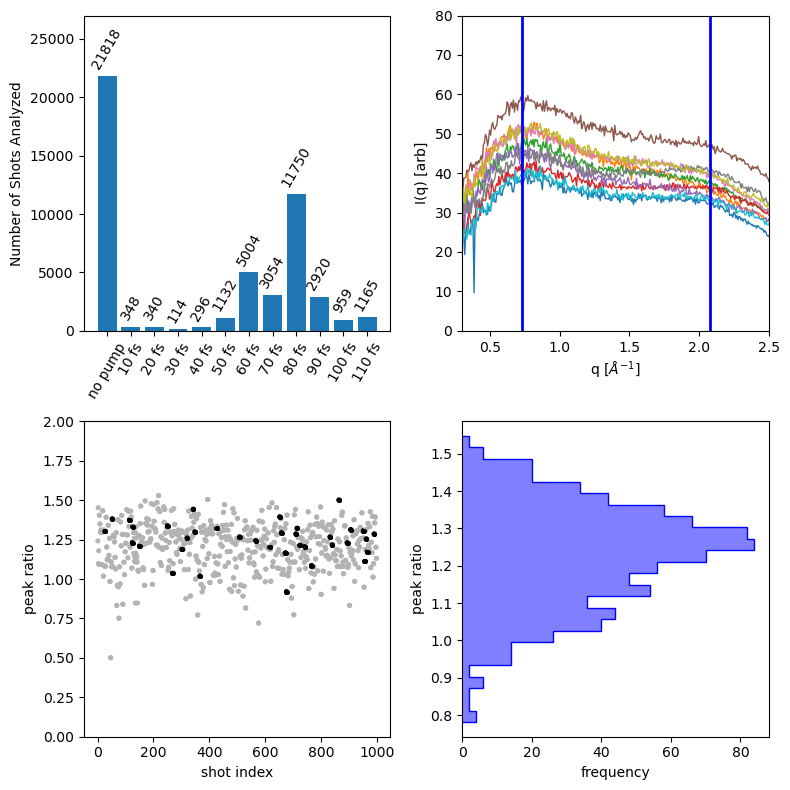

array([0. , 0.3, 0.3, ..., 0.3, 0.3, 0.3])

In [31]:
SHOTS_PER_TIME_BIN = 12
MAX_PLOTS = 10
max_shots = 1000

plt.figure(figsize=(8,8))

ax_tl = plt.subplot(221)
ax_tr = plt.subplot(222)
ax_bl = plt.subplot(223)
ax_br = plt.subplot(224)

bar_plot = ax_tl.bar(time_delay_bin_names, shot_counts)
ax_tl.bar_label(bar_plot, padding=3, rotation=60)
ax_tl.tick_params(axis='x', labelrotation=60)
ax_tl.set_ylabel('Number of Shots Analyzed')
ax_tl.set_ylim([0, 27000])

n_plots = int(n_shots / SHOTS_PER_TIME_BIN + 1)

shot_index = np.random.uniform(0, pp_100fs_data_in_bin.shape[0], MAX_PLOTS).astype(int)
ax_tr.plot(
    q_values, 
    pp_100fs_data_in_bin[shot_index,:].T,
    lw=1
)

colors_per_point = np.copy(pp_delay_in_bin).astype(float)
colors_per_point[colors_per_point == 0] += 0.3
colors_per_point[0] = 0.0
peak_ratios = pp_100fs_data[:,new_peak_pos] / pp_100fs_data[:,wat_peak_pos]
p = ax_bl.scatter(
    np.arange(max_shots),
    peak_ratios[:max_shots],
    c=colors_per_point[:max_shots],
    s=7,
    cmap='binary'
)
keep = (colors_per_point == 1.0)[:max_shots]
p = ax_bl.scatter(
    np.arange(max_shots)[keep],
    peak_ratios[:max_shots][keep],
    c='k',
    s=7,
)

bins = 25
ax_br.hist(peak_ratios[pp_delay_in_bin], bins=bins, color='blue', orientation='horizontal', histtype='stepfilled', alpha=0.5)
ax_br.hist(peak_ratios[pp_delay_in_bin], bins=bins, color='blue', orientation='horizontal', histtype='step')

ax_tr.vlines([q_values[new_peak_pos], q_values[wat_peak_pos]], 0, 80, color='blue', lw=2)
ax_tr.set_xlabel("q [$\AA^{-1}$]")
ax_tr.set_ylabel("I(q) [arb]")
ax_tr.set_xlim(XLIM)
ax_tr.set_ylim([0, 80])

ax_bl.set_ylim([0,2])
ax_bl.set_xlabel("shot index")
ax_bl.set_ylabel("peak ratio")

ax_br.set_xlabel("frequency")
ax_br.set_ylabel("peak ratio")

plt.tight_layout()
plt.savefig("shot-to-shot_variability.pdf")
plt.show()

colors_per_point